In [1]:
# loading the data
from os import listdir
import pandas as pd
import matplotlib.pyplot as plt
from scipy import misc
import csv
import numpy as np
from scipy import misc

CAR_DIR = './vehicles/'
NON_CAR_DIR = './non-vehicles/'
W = 32
H = 32
def load_examples(dir):
    examples = []
    for subdir in listdir(dir):
        try:
            for f_name in listdir(dir + subdir):
                try:
                    img = misc.imread(dir + subdir + '/' + f_name)
                    img = misc.imresize(img, (H,W,3))
                    #if img.shape != (64, 64, 3) : print ("AAAAAAAA")
                    examples.append(img)
                except IOError: pass
        except NotADirectoryError: pass
    return examples

car_img = load_examples(CAR_DIR)
non_car_img = load_examples(NON_CAR_DIR)

print ("Car examples: ", len(car_img))
print ("Non-Car examples: ", len(non_car_img))




Car examples:  8792
Non-Car examples:  8968


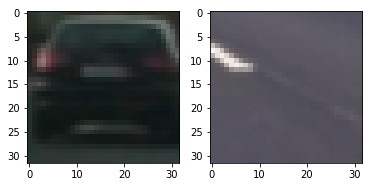

In [2]:
%matplotlib inline
plt.subplot(1,2,1)
plt.imshow(car_img[600])
plt.subplot(1,2,2)
plt.imshow(non_car_img[600])

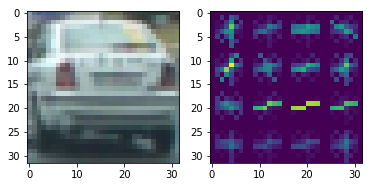

In [3]:
# getting the features
from skimage.feature import hog
import cv2

def hog_features(img):
    return hog(img, visualise=True)

def features_from_img(image):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)[:,:,1]
    vec = hog(img, visualise=False)
    return vec

img = car_img[2701]
vec, hogs = hog_features(cv2.cvtColor(img, cv2.COLOR_BGR2HLS)[:,:,1])
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(hogs)



8792 8968
X_train: 15096
X_test: 2664
y_train: 15096
y_test: 2664


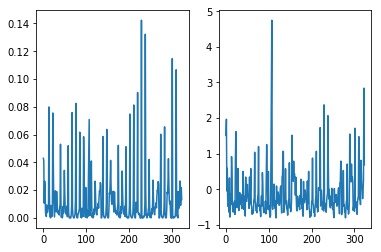

In [4]:
# building the training sets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

car_features = [features_from_img(img) for img in car_img]
non_car_features = [features_from_img(img) for img in non_car_img]
features = car_features + non_car_features

# before standardization
plt.subplot(1,2,1)
plt.plot(features[10])

# after the standardization
scaler = StandardScaler()
scaler.fit(features)
features = scaler.transform(features)
plt.subplot(1,2,2)
plt.plot(features[10])

labels = [1 for i in range(len(car_features))] + [0 for i in range(len(non_car_features))]
print (len(car_features), len(non_car_features))


X_train, X_test, y_train, y_test =  train_test_split(features, labels, test_size=0.15, random_state=999)

print('X_train:' , len(X_train))
print('X_test:' , len(X_test))
print('y_train:' , len(y_train))
print('y_test:' , len(y_test))

In [5]:
import time
t = time.time()

n = len(X_train)
# training
from sklearn.svm import SVC
clf = SVC()
clf.fit(X_train[:n],y_train[:n])
print("Time:", time.time() - t)

Time: 18.039775848388672


In [6]:
print(clf.score(X_train[:n], y_train[:n]))
#print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.989334923158
0.97484984985


(720, 1280, 3)


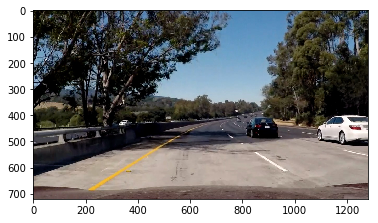

In [7]:
#loading the test data
TEST_DIR = './test_images/'
test_frames = []
for f_name in listdir(TEST_DIR):
    try:
        test_frames.append(misc.imread(TEST_DIR + f_name))
    except OSError: pass

print(test_frames[0].shape)
plt.imshow(test_frames[4])

In [11]:
def get_islands(heat_map):
    
    
    island_list = []

    #concave_found = True
    concave_found = False
    
    while concave_found:
        concave_found = False
        for y in range(heat_map.shape[0]-1):
            for x in range(heat_map.shape[1]-1):
                if heat_map[y,x] == 0 and heat_map[y,x+1] != 0 and heat_map[y+1,x] != 0:
                    heat_map[y,x] = 1
                    concave_found = True
                    
    y_i, x_i = np.where(heat_map != 0)
    
    for c in range(len(y_i)):
        y, x = y_i[c], x_i[c]
        
        island_found = False
        for island in island_list:
            for el_y, el_x in island:
                if (abs(el_y - y) == 1 and el_x == x) or (abs(el_x - x) == 1 and el_y == y):
                    island.append((y, x))
                    island_found = True
                    break
        
        if island_found == False:
            new_island = [(y,x)]
            island_list.append(new_island)
        
    return island_list
    
def get_squares(islands):
    squares = []
    for island in islands:
        y1, x1, y2, x2 = 99999, 99999, 0, 0
        for y, x in island:
            if y < y1 : y1 = y
            if y > y2 : y2 = y
            if x < x1 : x1 = x
            if x > x2 : x2 = x
        squares.append(( y1, x1, y2, x2))
    return squares

            

                    
            
            
            

t = np.array([[0,1,0,0,0,0],
              [1,1,1,0,0,0],
              [0,0,0,0,0,0],
              [0,0,0,0,0,0],
              [0,0,0,1,1,1],
              [0,0,0,0,1,1]]
              )
islands = get_islands(t)
print (islands)
print (get_squares(islands))

[[(0, 1), (1, 1), (1, 2)], [(1, 0), (1, 1), (1, 2)], [(4, 3), (4, 4), (4, 5), (5, 4), (5, 5)]]
[(0, 1, 1, 2), (1, 0, 1, 2), (4, 3, 5, 5)]


In [21]:
# the sliding logic
def get_boxes(shape=(720, 1280), box_size=100, step=0.5 , top_crop=350, bottom_crop=200, left_crop=200, right_crop=0):
    box_list = []
    y = top_crop
    while y < shape[0] - bottom_crop:
        x = left_crop
        while x < shape[1] - right_crop:
            box_list.append((y, x, y + box_size, x + box_size))
            x += int(box_size * step)
        y += int(box_size * step)
    return box_list

from skimage import draw
img = np.copy(test_frames[4])

heat_map = []

def process_frame(image, threshold = 20):
    img = np.copy(image)
    chunk_coords = []
    chunk_coords += get_boxes(box_size=70, step=0.5)
    chunk_coords += get_boxes(box_size=100, step=0.5)
    chunk_coords += get_boxes(box_size=150, step=0.5)
    chunk_coords += get_boxes(box_size=200, step=0.5)

    
    chunks = []
    for y1, x1, y2, x2 in chunk_coords:
        chunk = misc.imresize(img[y1:y2, x1:x2], (H,W))
        chunks.append(chunk)
    
    preds = clf.predict(scaler.transform([features_from_img(ch) for ch in chunks]))    
    matching_indices = [i for i,x in enumerate(preds) if x == 1]

    heat_frame = np.zeros((img.shape[0], img.shape[1]))
    
    for i in matching_indices:
        y1, x1, y2, x2 = chunk_coords[i]
        img[y1:y2, x1:x2,1] = 200
        heat_frame[y1:y2, x1:x2] += 1

    heat_map.append(heat_frame)
    
    hf = np.sum(heat_map[-10:], axis=0)
    hf[hf < threshold] = 0
    
    #print (get_squares(get_islands(hf)))
    
    
    
    
    heat_rgb = np.zeros(img.shape)
    heat_rgb[:,:,0] = hf
    #heat_rgb[:,:,1] = heat_frame
    #heat_rgb[:,:,2] = heat_frame
    heat_rgb = heat_rgb * 3  ######/ np.max(heat_rgb) * 255
    
    return np.concatenate((image + heat_rgb, heat_rgb), axis=1)




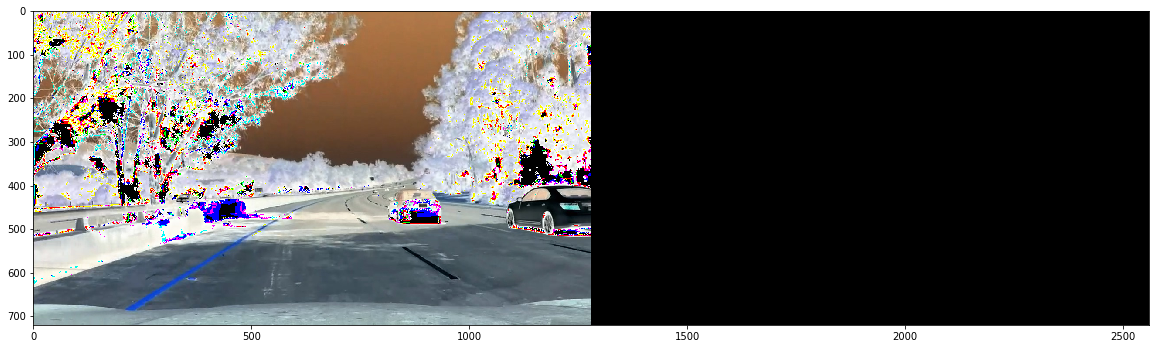

In [22]:
plt.figure(figsize=(20,20))
plt.imshow(process_frame(img))

In [23]:
from moviepy.editor import VideoFileClip

def write_video(input_f, output_f, f):
    clip = VideoFileClip(input_f).subclip(35,38)
    transformed = clip.fl_image(f)
    transformed.write_videofile(output_f, audio=False)

#INPUT_VIDEO = './test_video.mp4'
INPUT_VIDEO = './project_video.mp4'

write_video(INPUT_VIDEO, './output_video1.mp4', process_frame)


[MoviePy] >>>> Building video ./output_video1.mp4
[MoviePy] Writing video ./output_video1.mp4


 99%|█████████▊| 75/76 [00:48<00:00,  1.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_video1.mp4 

